In [12]:
import math
from mxnet import gluon, np, npx 
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

#### Generating the Dataset

In [13]:
max_degree = 20
n_train, n_test = 100, 100
true_w=np.zeros(max_degree)
true_w[0:4]=np.array([5,1.2,-3.4,5.6])

In [14]:
features=np.random.normal(size=(n_train+n_test,1))
np.random.shuffle(features)
poly_features=np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:,i]/=math.gamma(i+1)
labels=np.dot(poly_features,true_w)
labels+=np.random.normal(scale=0.1,size=labels.shape)


In [15]:
features[:2],poly_features[:2,:],labels[:2]

(array([[-1.0241255],
        [-0.8489916]]),
 array([[ 1.00000000e+00, -1.02412546e+00,  5.24416447e-01,
         -1.79022744e-01,  4.58354391e-02, -9.38824844e-03,
          1.60245725e-03, -2.34445339e-04,  3.00126794e-05,
         -3.41519444e-06,  3.49758722e-07, -3.25633494e-08,
          2.77907963e-09, -2.18932761e-10,  1.60153314e-11,
         -1.09344716e-12,  6.99891872e-14, -4.21633646e-15,
          2.39892066e-16, -1.29305039e-17],
        [ 1.00000000e+00, -8.48991573e-01,  3.60393345e-01,
         -1.01990305e-01,  2.16472279e-02, -3.67566268e-03,
          5.20101108e-04, -6.30802097e-05,  6.69432075e-06,
         -6.31491332e-07,  5.36130784e-08, -4.13791401e-09,
          2.92754515e-10, -1.91189304e-11,  1.15941512e-12,
         -6.56222377e-14,  3.48204551e-15, -1.73895745e-16,
          8.20200118e-18, -3.66496277e-19]]),
 array([1.0022109, 2.2689602]))

##### Training and testing the model

In [16]:
def evaluate_loss(net,data_iter,loss):
    metric=d2l.Accumulator(2)
    for X,y in data_iter:
        l=loss(net(X),y)
        metric.add(l.sum(),d2l.size(l))
    return metric[0]/metric[1]

In [17]:
def train(train_features, test_features, train_labels,test_labels,num_epochs=400):
    loss=gluon.loss.L2Loss()
    net=nn.Sequential()
    net.add(nn.Dense(1,use_bias=False))
    net.initialize()
    batch_size=min(10,train_labels.shape[0])
    train_iter=d2l.load_array((train_features,train_labels),batch_size)
    test_iter=d2l.load_array((test_features,test_labels),batch_size,is_train=False)
    trainer=gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':0.01})
    animator=d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',
        xlim=[1,num_epochs],ylim=[1e-3,1e2],
        legend=['train','test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net,train_iter,loss,trainer)
        if epoch==0 or (epoch+1)%20 ==0:
            animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),
                                  evaluate_loss(net,test_iter,loss)))
    print('weight:',net[0].weight.data().asnumpy())

weight: [[ 4.9943523  1.2232665 -3.4019473  5.57946  ]]


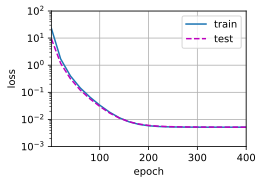

In [18]:
train(poly_features[:n_train,:4],poly_features[n_train:,:4],
    labels[:n_train],labels[n_train:])

#### Linear Function Fitting (Underfitting)

weight: [[3.1956537 5.197776 ]]


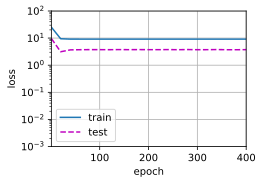

In [20]:
train(poly_features[:n_train,:2],poly_features[n_train:,:2],
        labels[:n_train],labels[n_train:])

#### Higher-Order Polynomial Function Fitting(Overfitting)

weight: [[ 4.997273    1.3718708  -3.4086504   4.9527636  -0.05289086  1.2566222
   0.20489983  0.08946849  0.06595588  0.0684391   0.04472536  0.05440088
  -0.00564364  0.05563262 -0.04850624 -0.02349272 -0.04205615  0.02980995
  -0.00938223 -0.01022792]]


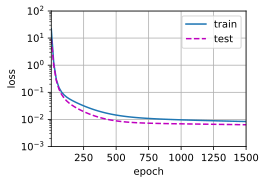

In [22]:
train(poly_features[:n_train,:],poly_features[n_train:,:],
        labels[:n_train],labels[n_train:],num_epochs=1500)